In [1]:
%matplotlib inline


Reconstruction of visual stimuli from Miyawaki et al. 2008
==========================================================

This example reproduces the experiment presented in
    `Visual image reconstruction from human brain activity
    using a combination of multiscale local image decoders
    <http://www.cell.com/neuron/abstract/S0896-6273%2808%2900958-6>`_,
    Miyawaki, Y., Uchida, H., Yamashita, O., Sato, M. A.,
    Morito, Y., Tanabe, H. C., ... & Kamitani, Y. (2008).
    Neuron, 60(5), 915-929.

It reconstructs 10x10 binary images from functional MRI data. Random images
are used as training set and structured images are used for reconstruction.

The code is a bit elaborate as the example uses, as the original article,
a multiscale prediction on the images seen by the subject.

See also
`sphx_glr_auto_examples_02_decoding_plot_miyawaki_encoding.py` for a
encoding approach for the same dataset.



In [2]:
# Some basic imports
import time
import sys

First we load the Miyawaki dataset
-----------------------------------



In [3]:
from nilearn import datasets
sys.stderr.write("Fetching dataset...")
t0 = time.time()

miyawaki_dataset = datasets.fetch_miyawaki2008()

# print basic information on the dataset
print('First functional nifti image (4D) is located at: %s' %
      miyawaki_dataset.func[0])  # 4D data

X_random_filenames = miyawaki_dataset.func[12:]
X_figure_filenames = miyawaki_dataset.func[:12]
y_random_filenames = miyawaki_dataset.label[12:]
y_figure_filenames = miyawaki_dataset.label[:12]
y_shape = (10, 10)

sys.stderr.write(" Done (%.2fs).\n" % (time.time() - t0))

/home/bertrand/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


First functional nifti image (4D) is located at: /home/bertrand/mygit/nilearn/nilearn_data/miyawaki2008/func/data_figure_run01.nii.gz


Fetching dataset... Done (0.00s).


Then we prepare and mask the data
----------------------------------



In [4]:
import numpy as np
from nilearn.input_data import MultiNiftiMasker

sys.stderr.write("Preprocessing data...")
t0 = time.time()

# Load and mask fMRI data
masker = MultiNiftiMasker(mask_img=miyawaki_dataset.mask, detrend=True,
                          standardize=False)
masker.fit()
X_train = masker.transform(X_random_filenames)
X_test = masker.transform(X_figure_filenames)

# We load the visual stimuli from csv files
y_train = []
for y in y_random_filenames:
    y_train.append(np.reshape(np.loadtxt(y, dtype=np.int, delimiter=','),
                              (-1,) + y_shape, order='F'))

y_test = []
for y in y_figure_filenames:
    y_test.append(np.reshape(np.loadtxt(y, dtype=np.int, delimiter=','),
                             (-1,) + y_shape, order='F'))

X_train = np.vstack([x[2:] for x in X_train])
y_train = np.vstack([y[:-2] for y in y_train]).astype(float)
X_test = np.vstack([x[2:] for x in X_test])
y_test = np.vstack([y[:-2] for y in y_test]).astype(float)

n_pixels = y_train.shape[1]
n_features = X_train.shape[1]


def flatten(list_of_2d_array):
    flattened = []
    for array in list_of_2d_array:
        flattened.append(array.ravel())
    return flattened


# Build the design matrix for multiscale computation
# Matrix is squared, y_rows == y_cols
y_cols = y_shape[1]

# Original data
design_matrix = np.eye(100)


# Example of matrix used for multiscale (sum pixels vertically)
#
# 0.5 *
#
# 1 1 0 0 0 0 0 0 0 0
# 0 1 1 0 0 0 0 0 0 0
# 0 0 1 1 0 0 0 0 0 0
# 0 0 0 1 1 0 0 0 0 0
# 0 0 0 0 1 1 0 0 0 0
# 0 0 0 0 0 1 1 0 0 0
# 0 0 0 0 0 0 1 1 0 0
# 0 0 0 0 0 0 0 1 1 0
# 0 0 0 0 0 0 0 0 1 1

height_tf = (np.eye(y_cols) + np.eye(y_cols, k=1))[:y_cols - 1] * .5
width_tf = height_tf.T

yt_tall = [np.dot(height_tf, m) for m in y_train]
yt_large = [np.dot(m, width_tf) for m in y_train]
yt_big = [np.dot(height_tf, np.dot(m, width_tf)) for m in y_train]

# Add it to the training set
y_train = [np.r_[y.ravel(), t.ravel(), l.ravel(), b.ravel()]
           for y, t, l, b in zip(y_train, yt_tall, yt_large, yt_big)]

y_test = np.asarray(flatten(y_test))
y_train = np.asarray(y_train)

# Remove rest period
X_train = X_train[y_train[:, 0] != -1]
y_train = y_train[y_train[:, 0] != -1]
X_test = X_test[y_test[:, 0] != -1]
y_test = y_test[y_test[:, 0] != -1]

sys.stderr.write(" Done (%.2fs).\n" % (time.time() - t0))

Preprocessing data... Done (38.50s).


We define our prediction function
-----------------------------------



In [5]:
sys.stderr.write("Training classifiers... \r")
t0 = time.time()

# OMP: Orthogonal Matching Pursuit
from sklearn.linear_model import OrthogonalMatchingPursuit as OMP
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.pipeline import Pipeline

# Create as many OMP as voxels to predict
clfs = []
n_clfs = y_train.shape[1]
for i in range(y_train.shape[1]):
    sys.stderr.write("Training classifiers %03d/%d... \r" % (i + 1, n_clfs))
    clf = Pipeline([('selection', SelectKBest(f_classif, 500)),
                    ('clf', OMP(n_nonzero_coefs=10))])
    clf.fit(X_train, y_train[:, i])
    clfs.append(clf)

sys.stderr.write("Training classifiers %03d/%d... Done (%.2fs).\n" % (
    n_clfs, n_clfs, time.time() - t0))

Training classifiers 361/361... Done (73.35s).


Here we run the prediction: the decoding itself
------------------------------------------------



In [6]:
sys.stderr.write("Calculating scores and outputs...")
t0 = time.time()

y_pred = []
for clf in clfs:
    y_pred.append(clf.predict(X_test))
y_pred = np.asarray(y_pred).T


# We need to the multi scale reconstruction
def split_multi_scale(y, y_shape):
    """ Split data into 4 original multi_scale images
    """
    yw, yh = y_shape

    # Index of original image
    split_index = [yw * yh]
    # Index of large image
    split_index.append(split_index[-1] + (yw - 1) * yh)
    # Index of tall image
    split_index.append(split_index[-1] + yw * (yh - 1))
    # Index of big image
    split_index.append(split_index[-1] + (yw - 1) * (yh - 1))

    # We split according to computed indices
    y_preds = np.split(y, split_index, axis=1)

    # y_pred is the original image
    y_pred = y_preds[0]

    # y_pred_tall is the image with 1x2 patch application. We have to make
    # some calculus to get it back in original shape
    height_tf_i = (np.eye(y_cols) + np.eye(y_cols, k=-1))[:, :y_cols - 1] * .5
    height_tf_i.flat[0] = 1
    height_tf_i.flat[-1] = 1
    y_pred_tall = [np.dot(height_tf_i, np.reshape(m, (yw - 1, yh))).flatten()
                   for m in y_preds[1]]
    y_pred_tall = np.asarray(y_pred_tall)

    # y_pred_large is the image with 2x1 patch application. We have to make
    # some calculus to get it back in original shape
    width_tf_i = (np.eye(y_cols) + np.eye(y_cols, k=1))[:y_cols - 1] * .5
    width_tf_i.flat[0] = 1
    width_tf_i.flat[-1] = 1
    y_pred_large = [np.dot(np.reshape(m, (yw, yh - 1)), width_tf_i).flatten()
                    for m in y_preds[2]]
    y_pred_large = np.asarray(y_pred_large)

    # y_pred_big is the image with 2x2 patch application. We use previous
    # matrices to get it back in original shape
    y_pred_big = [np.dot(np.reshape(m, (yw - 1, yh - 1)), width_tf_i)
                  for m in y_preds[3]]
    y_pred_big = [np.dot(height_tf_i, np.reshape(m, (yw - 1, yh))).flatten()
                  for m in y_pred_big]
    y_pred_big = np.asarray(y_pred_big)

    return (y_pred, y_pred_tall, y_pred_large, y_pred_big)


y_pred, y_pred_tall, y_pred_large, y_pred_big = \
    split_multi_scale(y_pred, y_shape)

y_pred = (.25 * y_pred + .25 * y_pred_tall + .25 * y_pred_large
          + .25 * y_pred_big)

sys.stderr.write(" Done (%.2fs).\n" % (time.time() - t0))

Calculating scores and outputs... Done (5.16s).


Let us quantify our prediction error
-------------------------------------



In [7]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score)

print("Scores")
print("------")
print("  - Accuracy (percent): %f" % np.mean([
    accuracy_score(y_test[:, i], y_pred[:, i] > .5) for i in range(100)]))
print("  - Precision: %f" % np.mean([
    precision_score(y_test[:, i], y_pred[:, i] > .5) for i in range(100)]))
print("  - Recall: %f" % np.mean([
    recall_score(y_test[:, i], y_pred[:, i] > .5) for i in range(100)]))
print("  - F1-score: %f" % np.mean([
    f1_score(y_test[:, i], y_pred[:, i] > .5) for i in range(100)]))

Scores
------
  - Accuracy (percent): 0.801208
  - Precision: 0.413969
  - Recall: 0.572388


/home/bertrand/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/bertrand/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


  - F1-score: 0.465973


And finally, we plot six reconstructed images, to compare with
ground truth



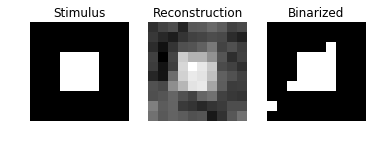

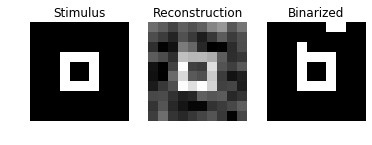

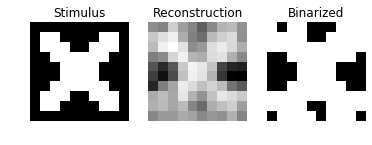

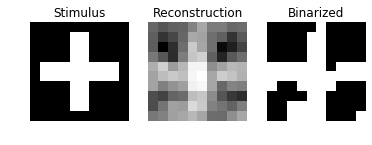

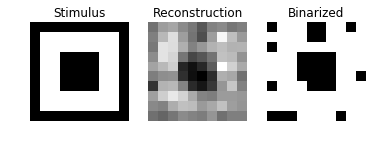

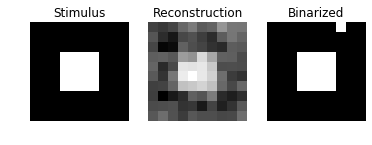

In [8]:
from matplotlib import pyplot as plt
from nilearn.plotting import show

for i in range(6):
    j = 10 * i
    fig = plt.figure()
    sp1 = plt.subplot(131)
    sp1.axis('off')
    plt.title('Stimulus')
    sp2 = plt.subplot(132)
    sp2.axis('off')
    plt.title('Reconstruction')
    sp3 = plt.subplot(133)
    sp3.axis('off')
    plt.title('Binarized')
    sp1.imshow(np.reshape(y_test[j], (10, 10)), cmap=plt.cm.gray,
               interpolation='nearest'),
    sp2.imshow(np.reshape(y_pred[j], (10, 10)), cmap=plt.cm.gray,
               interpolation='nearest'),
    sp3.imshow(np.reshape(y_pred[j] > .5, (10, 10)), cmap=plt.cm.gray,
               interpolation='nearest')
    plt.savefig('miyawaki2008_reconstruction_%d' % i)

show()